# Financial Services competition at IE's MBD:
# Predict Credit Card Default

                                                      Pau Roger Puig-Sureda
                                                                 08/06/2018

### The competition:                                               

We get 2 csv's with with real (yet transformed for privacy) data from a bank.


The training set will contain the **target** binary variable, which will be a 1 if the customer's monthly credit card fee has been unpaid and 0 otherwise. That is the variable that the test dataset is missing and we will be trying to predict in this notebook.

--------------------------------------------------------------------------------

The features that will be in both datasets are the ones that follow:

**customerID** - Client unique identification.

**sex** - Sex (Female, Male).

**status** - Marital Status (Divorced, Married, Single, Unknown, Widower).

**age** - In years.

**externalScore** - Score provided by a third party about the risk of defaulting.

**indSimin** - A binary variable that indicates if the client has guarantors.

**indXlist** - A binary variable that indicates if the client has debts with official agencies published in public registers.

**indCreditBureau** - A binary variable that indicates if the client appears in the delinquency list Credit Bureau.

**indInternet** - A binary variable that indicates if the client asked for information about credit cards online.

**indBadDebt** -  A binary variable that indicates whether the actual debt is classified as 'sub-standard' or 'lower-quality' risk.

**salary** - Salary in intervals (None, <650, [650,1000), [1000,1300), [1300,1500), [1500,2000), [2000,3000), [3000,5000), [5000,8000), >8000 , Unknown).

**numLoans** - Number of active loans that the client has in the bank.

**numMortgages** - Number of active mortgages that the client has in the bank.

**channel** - Channel for which the credit card has been contracted (App, Branch, Call Center, External, Agent, Online, Recovery, Unknown).

**indBadLocation** - A binary varible indicanting if the client's adress is located in a low rent per capita zone.

**previous** - Client debt classification of the previous year (Default, Normal, Refinancing, Restructuring, Unpaid).

**sumExternalDefault** - The amount of money of the client's debs that are in default.

--------------------------------------------------------------------------------


## Initialization

In [1]:
import numpy as np
import pandas as pd
# from scipy import stats
# import itertools
from collections import Counter

# Visualization
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

# Modeling
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, \
                            confusion_matrix, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.ensemble

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
# Import datasets
train_df = pd.read_csv('./data/challenge_train.csv')
test_df = pd.read_csv('./data/challenge_test.csv')

print(f"Shape of the train dataset: {train_df.shape}")
print(f"Shape of the test dataset: {test_df.shape}")

Shape of the train dataset: (522939, 18)
Shape of the test dataset: (174313, 17)


In [3]:
# Join Datasets so that I only have to do data cleaning and feature engeneering 
#  once. I will split them again before the modeling section.
df = train_df.append(test_df, ignore_index=True, sort=False)
df.shape

(697252, 18)

In [4]:
df.head()

,customerID,sex,status,age,externalScore,indSimin,indXlist,indCreditBureau,indInternet,indBadDebt,salary,numLoans,numMortgages,channel,indBadLocation,previous,sumExternalDefault,target
0,D_00046780637,Female,Single,23.0,373.0,0,0,0,1,1,"[1000,1300)",NaN,NaN,External Agent,0,Normal,1173.46,1.0
1,D_00043828980,Male,Single,27.0,702.0,1,0,0,1,0,"[1500,2000)",1.0,0.0,External Agent,0,Restructuring,0.00,0.0
2,D_00043396577,Male,Single,28.0,728.0,0,0,0,1,0,"[1500,2000)",2.0,0.0,External Agent,0,Restructuring,0.00,1.0
3,D_00006768677,Male,Single,45.0,650.0,0,0,0,0,0,"[1000,1300)",1.0,0.0,Call Center,0,Unpaid,0.00,1.0
4,D_00062632001,Female,Unknown,NaN,625.0,0,0,0,1,0,"[650,1000)",NaN,NaN,External Agent,0,Normal,0.00,0.0


In [5]:
df.columns

Index(['customerID', 'sex', 'status', 'age', 'externalScore', 'indSimin', 'indXlist', 'indCreditBureau', 'indInternet', 'indBadDebt', 'salary', 'numLoans', 'numMortgages', 'channel', 'indBadLocation', 'previous', 'sumExternalDefault', 'target'], dtype='object')

## Data cleaning & feature engineering

In [6]:
# Check null values
df.isnull().sum()

customerID                 0
sex                        0
status                     0
age                    30173
externalScore          11070
indSimin                   0
indXlist                   0
indCreditBureau            0
indInternet                0
indBadDebt                 0
salary                     0
numLoans              340980
numMortgages          340980
channel                    0
indBadLocation             0
previous                   0
sumExternalDefault      3554
target                174313
dtype: int64

An NA in '**numLoans**' and '**numMortages**' probably means 0 loans and mortages (at least with this bank).

In [7]:
df['numLoans'] = df['numLoans'].fillna(0)
df['numMortgages'] = df['numMortgages'].fillna(0)

print(f"Mortgages count:\n{Counter(df['numMortgages']).most_common()}\n")
print(f"Loans count:\n{Counter(df['numLoans']).most_common()}")

Mortgages count:
[(0.0, 680349), (1.0, 16568), (2.0, 325), (3.0, 10)]

Loans count:
[(0.0, 463452), (1.0, 121247), (2.0, 61166), (3.0, 30813), (4.0, 13645), (5.0, 5037), (6.0, 1483), (7.0, 327), (8.0, 70), (9.0, 10), (14.0, 1), (11.0, 1)]


NA's in **externalScore** is likely to belong to a young customer.

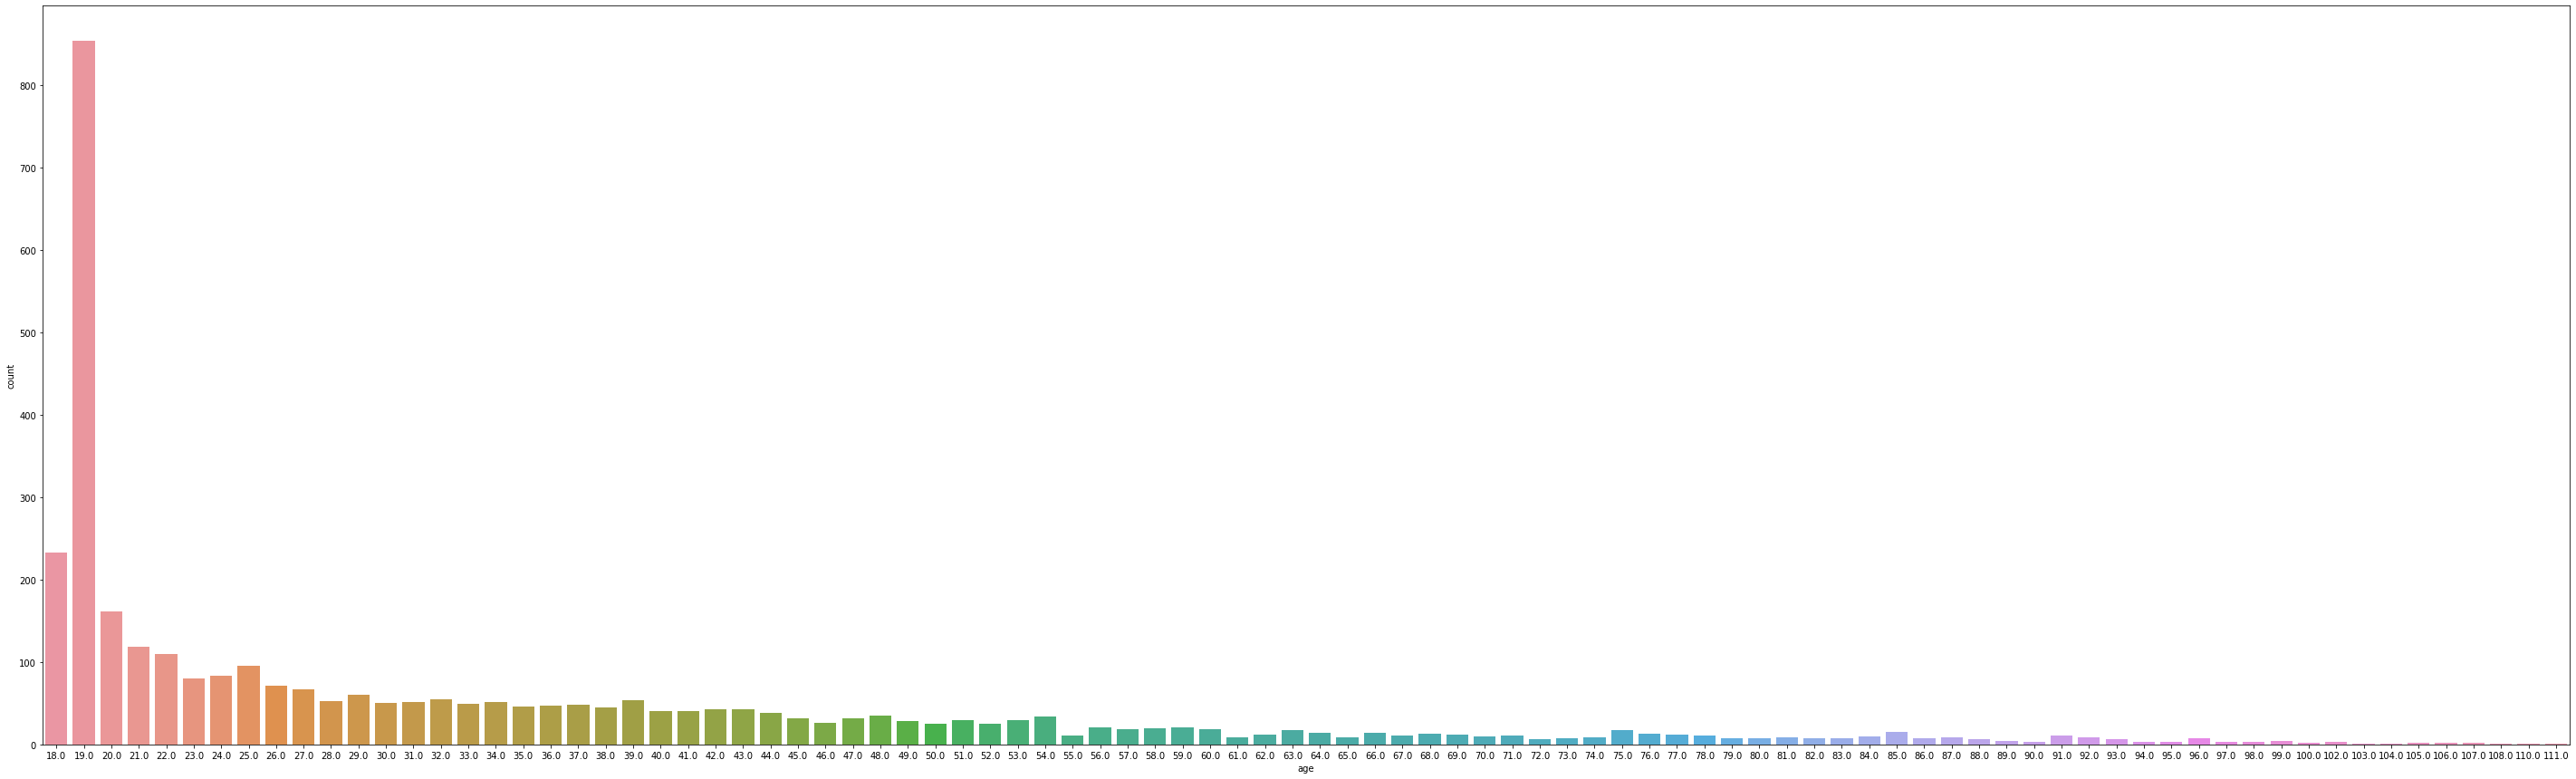

In [8]:
# Count plot of the age in the rows where the external score value is null.
plt.figure(figsize=(50, 15))
sns.countplot(df[df['externalScore'].isnull()]['age']);

The external score is not inmediate, it takes a while after the customer has an account set up. Hence, that is the reason for most of the NA's.

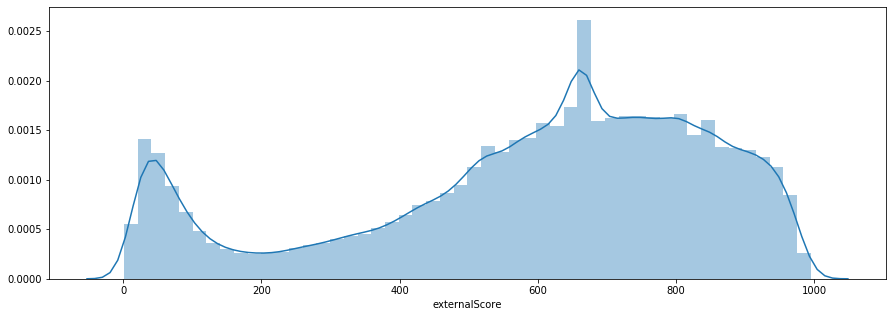

In [9]:
# Distribution plot of the rows without a null in external score.
plt.figure(figsize=(15,5))
sns.distplot(df[df['externalScore'].notnull()]['externalScore']);

In [10]:
# Fill the NA's with the 0.
df['externalScore'] = df['externalScore'].fillna(0)

**External Default**: Amount of debt that has not been paid. It is likely that an NA here means that the client has no debt with the bank, else they would probably know about it.

In [11]:
df['sumExternalDefault'] = df['sumExternalDefault'].fillna(0)

**Age**: As we saw before, most people with no **external score** are very young, so I will input the NA's in the feature **age** based on the median of the **externalScore**.

In [12]:
df.loc[df['externalScore'] == 0, 
       'age'] = df[df['externalScore'] == 0]['age'].mode()[0]

Regarding the remaining NA's, we will input them based on the customer's salary category median.

In [13]:
print(f"Salary categories:\n{df['salary'].unique()}")

Salary categories:
['[1000,1300)' '[1500,2000)' '[650,1000)' '[2000,3000)' '[1300,1500)'
 '>8000' '[3000,5000)' '<650' '[5000,8000)' 'Unknown' 'None']


In [14]:
df.loc[(df['age'].isnull()) & (df['salary'] == '[5000,8000)'), 
       'age'] = df[df['salary'] == '[5000,8000)']['age'].median()[0]

df.loc[(df['age'].isnull()) & (df['salary'] == '[3000,5000)'), 
       'age'] = df[df['salary'] == '[3000,5000)']['age'].median()[0]

df.loc[(df['age'].isnull()) & (df['salary'] == '[2000,3000)'), 
       'age'] = df[df['salary'] == '[2000,3000)']['age'].median()[0]

df.loc[(df['age'].isnull()) & (df['salary'] == '[1500,2000)'), 
       'age'] = df[df['salary'] == '[1500,2000)']['age'].median()[0]

df.loc[(df['age'].isnull()) & (df['salary'] == '[1300,1500)'), 
       'age'] = df[df['salary'] == '[1300,1500)']['age'].median()[0]

df.loc[(df['age'].isnull()) & (df['salary'] == '[1000,1300)'), 
       'age'] = df[df['salary'] == '[1000,1300)']['age'].median()[0]

df.loc[(df['age'].isnull()) & (df['salary'] == '[650,1000)'), 
       'age'] = df[df['salary'] == '[650,1000)']['age'].median()[0]

df.loc[(df['age'].isnull()) & (df['salary'] == '<650'), 
       'age'] = df[df['salary'] == '<650']['age'].median()[0]

# In case we still have some remaining NA's, let's input to them the population 
#  median.
df['age'] = df['age'].fillna(df['age'].median()[0])

#### CustomerID

In [15]:
print(f"Customers with more than one account: \n"
      f"{df['customerID'].duplicated().sum()}")

Customers with more than one account: 
19466


In [16]:
# With the duplicates we will create a new feature called multipleAccounts.
df["multipleAccounts"] = df['customerID'].duplicated().astype(int)

print(f"Binnary variable count of the users with multiple accounts: \n"
      f"{Counter(df['multipleAccounts'])}")

Binnary variable count of the users with multiple accounts: 
Counter({0: 677786, 1: 19466})


In [17]:
# Set this variable as the index of the main df
# df.set_index('customerID', inplace=True)

In [18]:
# Save variable, will set it up as index later.
customer_df = df['customerID']

del df['customerID']

#### Binnary variables

In [19]:
# Will transform sex to a binnary variable.
df.loc[df['sex'] == 'Female', 'sex'] = 0
df.loc[df['sex'] == 'Male', 'sex'] = 1

#### Salary, Channel, Previous & Status

In [20]:
print(f"Count instances for the categorical features:\n\n"
      f"'salary':\n{Counter(df['salary'])}\n\n"
      f"'channel':\n{Counter(df['channel'])}\n\n"
      f"'previous':\n{Counter(df['previous'])}\n\n"
      f"'status':\n{Counter(df['status'])}")

Count instances for the categorical features:

'salary':
Counter({'[1000,1300)': 349734, '[1500,2000)': 79699, '[1300,1500)': 75020, '[650,1000)': 71473, '[2000,3000)': 50983, '<650': 26210, '[3000,5000)': 22538, '[5000,8000)': 9594, 'None': 4667, '>8000': 4097, 'Unknown': 3237})

'channel':
Counter({'External Agent': 360708, 'Branch': 115505, 'Call Center': 108113, 'Recovery': 65771, 'App': 26548, 'Online': 16523, 'Unknown': 4084})

'previous':
Counter({'Normal': 399544, 'Restructuring': 140851, 'Refinancing': 107755, 'Default': 24596, 'Unpaid': 24506})

'status':
Counter({'Single': 574387, 'Married': 90790, 'Unknown': 26618, 'Widower': 5080, 'Divorced': 377})


In [21]:
# We will dummify these object variables
factor_df = df[df.select_dtypes(include=['object']).columns.tolist()]
factor_df = pd.get_dummies(factor_df)

# Join the dummifie variables to the main df
df = pd.concat([df, factor_df], 
               axis=1, 
               copy=False)

# Delete the initial categorical variables
del df['status']
del df['salary']
del df['channel']
del df['previous']

In [22]:
# Next, we will factor the binnary variables as frequencies.
# We do not want to do that with the target variable, which is why we will 
#  take it out before doing the transformation.
non_target_df = df[:]
del non_target_df['target']
target_df = df['target']

# New dataframes based on their datatypes.
binnary_df = \
  non_target_df[non_target_df.select_dtypes(include=['int64', 
                                                     'uint8']).columns.tolist()]
float_df = \
  non_target_df[non_target_df.select_dtypes(include=['float64']).columns.tolist()]

# Get feature frequencies.
for column in binnary_df.columns:
    binnary_df.loc[binnary_df[column]==0, 
                   column] = Counter(binnary_df[column])[0]/binnary_df.shape[0]
    binnary_df.loc[binnary_df[column]==1, 
                   column] = Counter(binnary_df[column])[1]/binnary_df.shape[0]
    
# Join back to the main df the factorized, float, customer and target variables.
df = pd.concat([float_df, binnary_df, customer_df, target_df], 
               axis=1, 
               copy=False)

In [23]:
# Set customer id as the index.
df.set_index('customerID', inplace=True)

In [24]:
# First few rows of the final dataframe.
df.head()

,age,externalScore,numLoans,numMortgages,sumExternalDefault,sex,indSimin,indXlist,indCreditBureau,indInternet,indBadDebt,indBadLocation,multipleAccounts,status_Divorced,status_Married,status_Single,status_Unknown,status_Widower,salary_<650,salary_>8000,salary_None,salary_Unknown,"salary_[1000,1300)","salary_[1300,1500)","salary_[1500,2000)","salary_[2000,3000)","salary_[3000,5000)","salary_[5000,8000)","salary_[650,1000)",channel_App,channel_Branch,channel_Call Center,channel_External Agent,channel_Online,channel_Recovery,channel_Unknown,previous_Default,previous_Normal,previous_Refinancing,previous_Restructuring,previous_Unpaid,target
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
D_00046780637,23.0,373.0,0.0,0.0,1173.46,0.627498,0.901221,0.946371,0.957628,0.775035,0.29076,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.96241,0.994124,0.993307,0.995357,0.501589,0.892406,0.885696,0.92688,0.967676,0.98624,0.897493,0.961925,0.834343,0.844944,0.517328,0.976303,0.905671,0.994143,0.964724,0.573027,0.845458,0.797991,0.964853,1.0
D_00043828980,27.0,702.0,1.0,0.0,0.00,0.372502,0.098779,0.946371,0.957628,0.775035,0.70924,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.96241,0.994124,0.993307,0.995357,0.498411,0.892406,0.114304,0.92688,0.967676,0.98624,0.897493,0.961925,0.834343,0.844944,0.517328,0.976303,0.905671,0.994143,0.964724,0.426973,0.845458,0.202009,0.964853,0.0
D_00043396577,28.0,728.0,2.0,0.0,0.00,0.372502,0.901221,0.946371,0.957628,0.775035,0.70924,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.96241,0.994124,0.993307,0.995357,0.498411,0.892406,0.114304,0.92688,0.967676,0.98624,0.897493,0.961925,0.834343,0.844944,0.517328,0.976303,0.905671,0.994143,0.964724,0.426973,0.845458,0.202009,0.964853,1.0
D_00006768677,45.0,650.0,1.0,0.0,0.00,0.372502,0.901221,0.946371,0.957628,0.224965,0.70924,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.96241,0.994124,0.993307,0.995357,0.501589,0.892406,0.885696,0.92688,0.967676,0.98624,0.897493,0.961925,0.834343,0.155056,0.482672,0.976303,0.905671,0.994143,0.964724,0.426973,0.845458,0.797991,0.035147,1.0
D_00062632001,21.0,625.0,0.0,0.0,0.00,0.627498,0.901221,0.946371,0.957628,0.775035,0.70924,0.830453,0.972082,0.999459,0.869789,0.176213,0.038176,0.992714,0.96241,0.994124,0.993307,0.995357,0.498411,0.892406,0.885696,0.92688,0.967676,0.98624,0.102507,0.961925,0.834343,0.844944,0.517328,0.976303,0.905671,0.994143,0.964724,0.573027,0.845458,0.797991,0.964853,0.0


In [25]:
# Description of all the variables prior to the modeling bit
df.describe(include='all')

,age,externalScore,numLoans,numMortgages,sumExternalDefault,sex,indSimin,indXlist,indCreditBureau,indInternet,indBadDebt,indBadLocation,multipleAccounts,status_Divorced,status_Married,status_Single,status_Unknown,status_Widower,salary_<650,salary_>8000,salary_None,salary_Unknown,"salary_[1000,1300)","salary_[1300,1500)","salary_[1500,2000)","salary_[2000,3000)","salary_[3000,5000)","salary_[5000,8000)","salary_[650,1000)",channel_App,channel_Branch,channel_Call Center,channel_External Agent,channel_Online,channel_Recovery,channel_Unknown,previous_Default,previous_Normal,previous_Refinancing,previous_Restructuring,previous_Unpaid,target
count,697252.000000,697252.000000,697252.000000,697252.000000,6.972520e+05,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,697252.000000,522939.000000
mean,38.323278,581.965859,0.613329,0.024737,4.766903e+02,0.532511,0.821956,0.898494,0.918847,0.651289,0.587563,0.718398,0.945723,0.998919,0.773488,0.709676,0.926564,0.985535,0.927645,0.988317,0.986703,0.990758,0.500005,0.807965,0.797522,0.864453,0.937442,0.972859,0.816002,0.926749,0.723570,0.737973,0.500601,0.953728,0.829138,0.988354,0.931937,0.510666,0.738682,0.677598,0.932177,0.340265
std,14.030591,270.048314,1.071287,0.158567,9.689431e+03,0.123283,0.239421,0.201121,0.184366,0.229687,0.190037,0.247995,0.155540,0.023221,0.248894,0.246727,0.176990,0.083806,0.175904,0.075531,0.080448,0.067347,0.001589,0.243187,0.245442,0.222262,0.165426,0.113286,0.241130,0.176804,0.248599,0.249711,0.017318,0.144896,0.237144,0.075415,0.171461,0.072244,0.249744,0.239286,0.171206,0.473799
min,18.000000,0.000000,0.000000,0.000000,0.000000e+00,0.372502,0.098779,0.053629,0.042372,0.224965,0.290760,0.169547,0.027918,0.000541,0.130211,0.176213,0.038176,0.007286,0.037590,0.005876,0.006693,0.004643,0.498411,0.107594,0.114304,0.073120,0.032324,0.013760,0.102507,0.038075,0.165657,0.155056,0.482672,0.023697,0.094329,0.005857,0.035276,0.426973,0.154542,0.202009,0.035147,0.000000
25%,27.000000,443.000000,0.000000,0.000000,0.000000e+00,0.372502,0.901221,0.946371,0.957628,0.775035,0.290760,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.962410,0.994124,0.993307,0.995357,0.498411,0.892406,0.885696,0.926880,0.967676,0.986240,0.897493,0.961925,0.834343,0.844944,0.482672,0.976303,0.905671,0.994143,0.964724,0.426973,0.845458,0.797991,0.964853,0.000000
50%,36.000000,644.000000,0.000000,0.000000,0.000000e+00,0.627498,0.901221,0.946371,0.957628,0.775035,0.709240,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.962410,0.994124,0.993307,0.995357,0.501589,0.892406,0.885696,0.926880,0.967676,0.986240,0.897493,0.961925,0.834343,0.844944,0.517328,0.976303,0.905671,0.994143,0.964724,0.573027,0.845458,0.797991,0.964853,0.000000
75%,47.000000,789.000000,1.000000,0.000000,3.344250e+01,0.627498,0.901221,0.946371,0.957628,0.775035,0.709240,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.962410,0.994124,0.993307,0.995357,0.501589,0.892406,0.885696,0.926880,0.967676,0.986240,0.897493,0.961925,0.834343,0.844944,0.517328,0.976303,0.905671,0.994143,0.964724,0.573027,0.845458,0.797991,0.964853,1.000000
max,108.000000,995.000000,14.000000,3.000000,6.021214e+06,0.627498,0.901221,0.946371,0.957628,0.775035,0.709240,0.830453,0.972082,0.999459,0.869789,0.823787,0.961824,0.992714,0.962410,0.994124,0.993307,0.995357,0.501589,0.892406,0.885696,0.926880,0.967676,0.986240,0.897493,0.961925,0.834343,0.844944,0.517328,0.976303,0.905671,0.994143,0.964724,0.573027,0.845458,0.797991,0.964853,1.000000


In [26]:
# Split dataset in train and test again
train = df[df['target'].notnull()]
train['target'] = train['target'].astype(int)

test = df[df['target'].isnull()]
del test['target']

print(f"Train dataframe shape: {train.shape}")
print(f"Test dataframe shape: {test.shape}")

Train dataframe shape: (522939, 42)
Test dataframe shape: (174313, 41)


## Modeling

In [27]:
# Baseline.
print(Counter(train['target']))
print(f"\nA model that would output all zeroes would have an accuracy of "
      f"{round(Counter(train['target'])[0] * 100 /train.shape[0], 2)}%")

Counter({0: 345001, 1: 177938})

A model that would output all zeroes would have an accuracy of 65.97%


The compempetition, however, is scored based on the AUC.

In [28]:
# Split training set into tran and validation
X_train, X_test, y_train, y_test = train_test_split(train.drop('target',axis=1), 
                                                    train['target'], 
                                                    random_state=111, 
                                                    test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(418351, 41) (418351,)
(104588, 41) (104588,)


In [29]:
# Logistic regression. Model Baseline.
logreg = linear_model.LogisticRegression(C=1e5, 
                                         solver='liblinear',
                                         max_iter=1000,
                                         class_weight='balanced',
                                         random_state=111,
                                         verbose=1,
                                         warm_start=True)
logreg.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=111, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=True)

In [30]:
y_pred_logreg = logreg.predict(X_test)

print("Cross validated AUC: \n")
print(cross_val_score(logreg, 
                    X_test, 
                    y_test, 
                    scoring='roc_auc', 
                    cv=5))

print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg)}\n")
print(f"Recall: {recall_score(y_test, y_pred_logreg)}\n")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_logreg)}\n")

Cross validated AUC: 

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][0.70563988 0.70499707 0.70478027 0.70463358 0.70109799]
Accuracy: 0.6521971927945844

Recall: 0.6512421396948933

Confusion Matrix: 
[[45117 24008]
 [12368 23095]]



In [31]:
#H2O Auto ML

# Start an H2O virtual cluster
h2o.init() 

# Clean up the cluster just in case
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11" 2018-09-25; Java(TM) SE Runtime Environment 18.9 (build 11+28); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11+28, mixed mode)
  Starting server from /usr/local/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xl/khqc2hb16yd7tbyr_nnj_1pw0000gn/T/tmpabjslv5g
  JVM stdout: /var/folders/xl/khqc2hb16yd7tbyr_nnj_1pw0000gn/T/tmpabjslv5g/h2o_pauroger_started_from_python.out
  JVM stderr: /var/folders/xl/khqc2hb16yd7tbyr_nnj_1pw0000gn/T/tmpabjslv5g/h2o_pauroger_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Malta
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_pauroger_o6m4bf
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [32]:
values = train.values
features_names = train.columns.values.tolist()

# Dataframe to H2o frame
hf = h2o.H2OFrame(train.values)
hf.set_names(features_names)

# Target variable as factor, all the rest will be numeric
hf['target'] = hf['target'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
# Train multiple models
aml = H2OAutoML(max_models = 10, 
                seed = 1,
                max_runtime_secs = 7200,
                sort_metric='AUC', 
                verbosity = 'info') 

aml.train(x = features_names, y = "target", training_frame = hf)

AutoML progress: |
12:15:50.482: Project: automl_py_2_sid_a8a8
12:15:50.482: AutoML job created: 2019.10.17 12:15:50.479
12:15:50.483: Build control seed: 1
12:15:50.485: training frame: Frame key: automl_training_py_2_sid_a8a8    cols: 42    rows: 522939  chunks: 89    size: 42272171  checksum: 7311542912917422784
12:15:50.485: validation frame: NULL
12:15:50.485: leaderboard frame: NULL
12:15:50.485: response column: target
12:15:50.485: fold column: null
12:15:50.485: weights column: null
12:15:50.539: Setting stopping tolerance adaptively based on the training frame: 0.001382848121162852
12:15:50.550: AutoML build started: 2019.10.17 12:15:50.549

██████████
12:35:21.461: New leader: XGBoost_1_AutoML_20191017_121550, auc: 0.7162676969108528

██████████████████████
13:24:20.151: AutoML: starting GLM hyperparameter search

███████████████████████
13:43:36.678: New leader: StackedEnsemble_BestOfFamily_AutoML_20191017_121550, auc: 0.7166842174247587

█| 100%

13:43:58.724: New leader: 

In [34]:
# Save and print model leaderboard
lb = aml.leaderboard 
lb 

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191017_121550,0.71699,0.573738,0.344795,0.441769,0.19516
StackedEnsemble_BestOfFamily_AutoML_20191017_121550,0.716684,0.573936,0.34714,0.441872,0.195251
XGBoost_1_AutoML_20191017_121550,0.716268,0.573248,0.347643,0.441713,0.19511
GBM_2_AutoML_20191017_121550,0.715825,0.573516,0.349083,0.441855,0.195236
GBM_3_AutoML_20191017_121550,0.715796,0.57352,0.350727,0.441848,0.19523
GBM_1_AutoML_20191017_121550,0.715157,0.573996,0.349791,0.442091,0.195444
GBM_4_AutoML_20191017_121550,0.715092,0.574081,0.350182,0.442093,0.195446
GBM_5_AutoML_20191017_121550,0.714478,0.574474,0.349958,0.442245,0.195581
XGBoost_3_AutoML_20191017_121550,0.714021,0.574877,0.351922,0.44252,0.195824
XGBoost_2_AutoML_20191017_121550,0.711983,0.576118,0.35321,0.443036,0.196281


In [35]:
# Print leader model insights.
h2o.get_model(lb[0, "model_id"]) 

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20191017_121550

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.1890056211912897
RMSE: 0.4347477673217997
LogLoss: 0.5592808604603167
Null degrees of freedom: 522938
Residual degrees of freedom: 522930
Null deviance: 670628.7904031395
Residual deviance: 584939.5477765151
AIC: 584957.5477765151
AUC: 0.7382776064543449
pr_auc: 0.593557814109045
Gini: 0.47655521290868985

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28186035932045983: 


,,0,1,Error,Rate
0,0,199832.0,145169.0,0.4208,(145169.0/345001.0)
1,1,43056.0,134882.0,0.242,(43056.0/177938.0)
2,Total,242888.0,280051.0,0.3599,(188225.0/522939.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.281860,0.589019,270.0
1,max f2,0.166179,0.738748,354.0
2,max f0point5,0.448690,0.564717,173.0
3,max accuracy,0.493405,0.713986,150.0
4,max precision,0.880368,1.000000,0.0
5,max recall,0.100301,1.000000,398.0
6,max specificity,0.880368,1.000000,0.0
7,max absolute_mcc,0.374681,0.333028,213.0
8,max min_per_class_accuracy,0.325336,0.671751,242.0
9,max mean_per_class_accuracy,0.319477,0.672582,246.0



Gains/Lift Table: Avg response rate: 34.03 %, avg score: 34.03 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010001,0.787047,2.578687,2.578687,0.877438,0.822302,0.877438,0.822302,0.025790,0.025790,157.868739,157.868739
1,,2,0.020014,0.743297,2.324277,2.451409,0.790871,0.763650,0.834130,0.792959,0.023272,0.049062,132.427719,145.140936
2,,3,0.030002,0.712802,2.283922,2.395652,0.777140,0.726794,0.815157,0.770932,0.022811,0.071873,128.392245,139.565156
3,,4,0.040001,0.689720,2.153158,2.335034,0.732645,0.700693,0.794531,0.753374,0.021530,0.093403,115.315769,133.503389
4,,5,0.050000,0.671728,2.066604,2.281352,0.703194,0.680413,0.776265,0.738783,0.020665,0.114068,106.660424,128.135206
5,,6,0.100000,0.607457,1.912011,2.096681,0.650591,0.637773,0.713428,0.688278,0.095601,0.209669,91.201064,109.668135
6,,7,0.150000,0.552632,1.708794,1.967386,0.581443,0.579799,0.669433,0.652118,0.085440,0.295108,70.879418,96.738563
7,,8,0.200000,0.499772,1.568408,1.867641,0.533675,0.525521,0.635494,0.620469,0.078421,0.373529,56.840847,86.764134
8,,9,0.300001,0.414131,1.361651,1.698978,0.463323,0.455076,0.578103,0.565338,0.136165,0.509694,36.165146,69.897804
9,,10,0.400001,0.351008,1.168382,1.566329,0.397560,0.382106,0.532967,0.519530,0.116838,0.626533,16.838226,56.632910




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.19516017438754968
RMSE: 0.44176936786919674
LogLoss: 0.5737377469774955
Null degrees of freedom: 522938
Residual degrees of freedom: 522930
Null deviance: 670629.7124725569
Residual deviance: 600059.687333329
AIC: 600077.687333329
AUC: 0.716990471907564
pr_auc: 0.5612860085973458
Gini: 0.4339809438151281

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28403741856714415: 


,,0,1,Error,Rate
0,0,198262.0,146739.0,0.4253,(146739.0/345001.0)
1,1,47022.0,130916.0,0.2643,(47022.0/177938.0)
2,Total,245284.0,277655.0,0.3705,(193761.0/522939.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.284037,0.574706,268.0
1,max f2,0.156615,0.731761,361.0
2,max f0point5,0.430389,0.542911,181.0
3,max accuracy,0.503526,0.702055,141.0
4,max precision,0.858587,0.895455,3.0
5,max recall,0.096316,1.000000,399.0
6,max specificity,0.878692,0.999983,0.0
7,max absolute_mcc,0.358109,0.303121,223.0
8,max min_per_class_accuracy,0.322650,0.657482,244.0
9,max mean_per_class_accuracy,0.324377,0.657943,243.0



Gains/Lift Table: Avg response rate: 34.03 %, avg score: 34.03 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010007,0.785319,2.431753,2.431753,0.827441,0.820790,0.827441,0.820790,0.024334,0.024334,143.175316,143.175316
1,,2,0.020000,0.742093,2.179700,2.305811,0.741676,0.762821,0.784587,0.791825,0.021783,0.046117,117.969983,130.581084
2,,3,0.030002,0.710996,2.078010,2.229872,0.707075,0.725343,0.758748,0.769663,0.020783,0.066900,107.800958,122.987225
3,,4,0.040001,0.689149,1.995226,2.171216,0.678906,0.699448,0.738790,0.752111,0.019951,0.086850,99.522574,117.121623
4,,5,0.050000,0.671786,1.903052,2.117587,0.647543,0.680140,0.720542,0.737718,0.019029,0.105880,90.305193,111.758747
5,,6,0.100000,0.606753,1.816922,1.967254,0.618235,0.637532,0.669388,0.687625,0.090846,0.196726,81.692152,96.725450
6,,7,0.150000,0.552751,1.656754,1.863754,0.563736,0.579553,0.634171,0.651601,0.082838,0.279564,65.675368,86.375422
7,,8,0.200000,0.499052,1.527945,1.779802,0.519907,0.525336,0.605605,0.620035,0.076397,0.355961,52.794502,77.980192
8,,9,0.300001,0.414873,1.350749,1.636784,0.459613,0.454812,0.556941,0.564961,0.135075,0.491036,35.074880,63.678422
9,,10,0.400001,0.351316,1.155456,1.516452,0.393162,0.382042,0.515996,0.519231,0.115546,0.606582,15.545643,51.645227


### Model conclusions

We can see that the AUC of the train set is 0.74 while the one in the cross-validated data is 0.72. From this we can extrapolate that the stacked ensabmle from all models can scale pretty well to unseen data. Hence, we will be using this one for the final submission.

In [36]:
# Make predictions with the model leader to the test set and save it into a df
hf_test = h2o.H2OFrame(test.values)
hf_test.set_names(test.columns.tolist())
predictions = aml.leader.predict(hf_test)
predictions_df = predictions.as_data_frame()
predictions_df['UserId'] = test.index

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [37]:
# Save the outoput dataframe into a csv
output_df = predictions_df[['UserId', 'p1', 'predict']]
output_df.to_csv('results.csv')

In [38]:
h2o.shutdown()

[WARNING] in <ipython-input-38-1edf85295eae> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_a8a8 closed.
